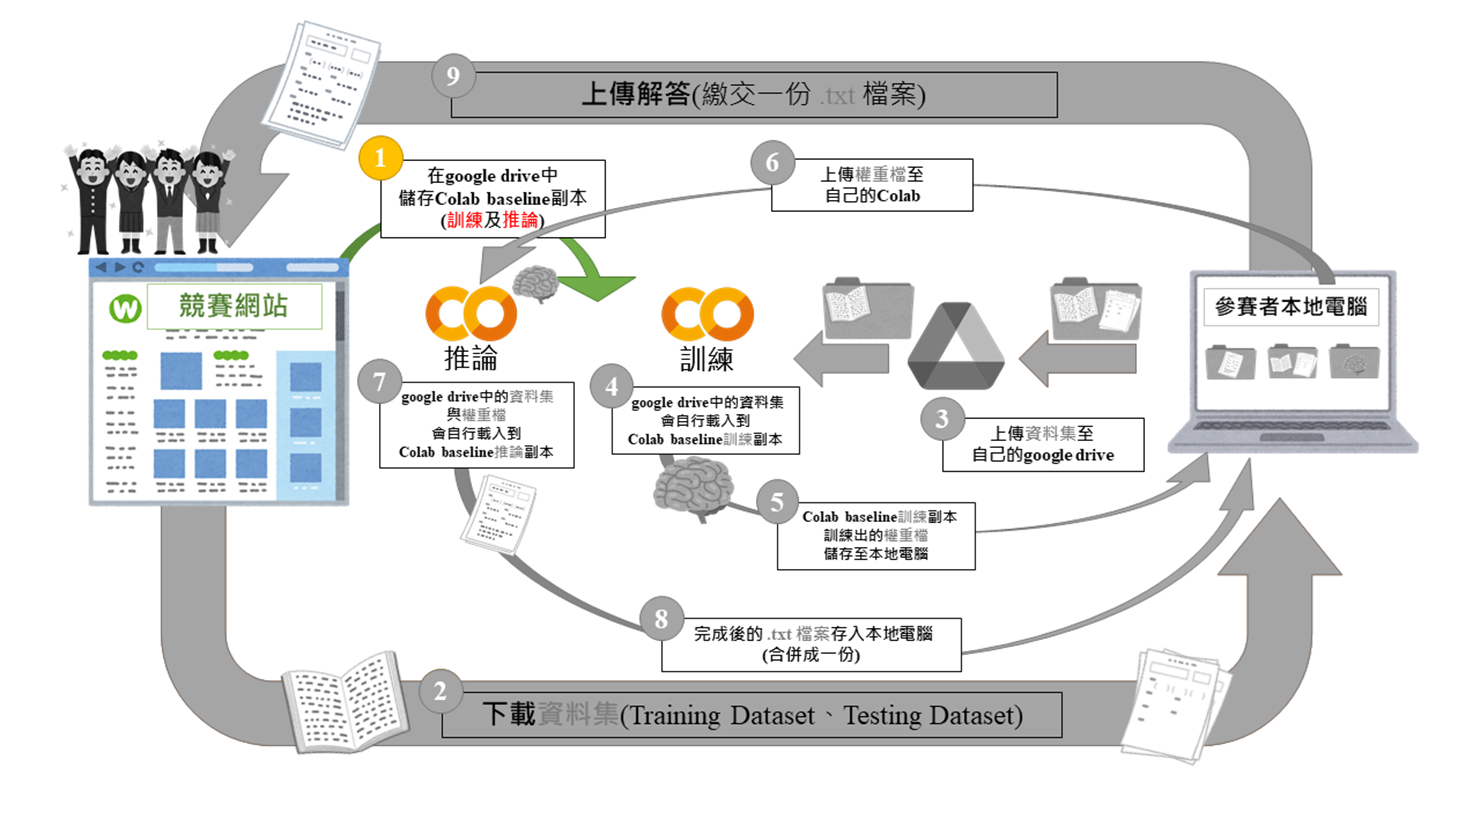

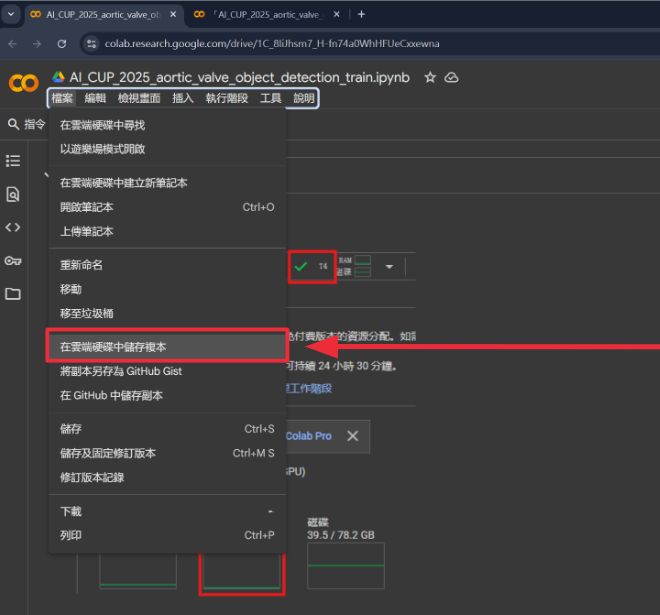

#### 1.設置環境

從畫面右上角確認有使用到GPU

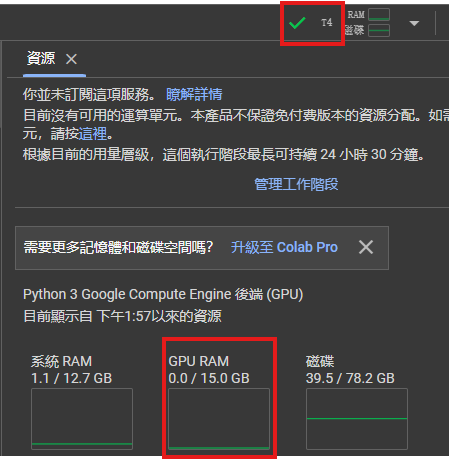

如果沒連到的話請切換到GPU

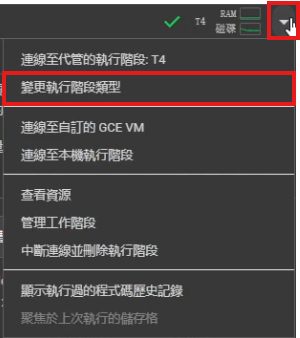
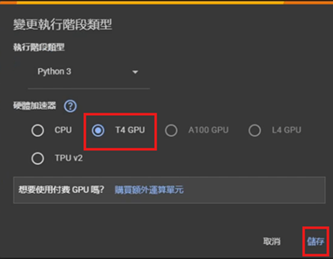

Colab區塊左方有綠色勾代表執行完成且成功 image.png


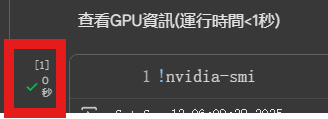

區塊左方有圈在轉代表執行中 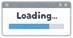

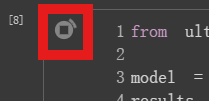

區塊左方有紅色驚嘆號代表運行錯誤 image.png

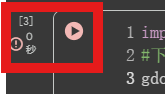

#=====================================================

#BLOCK 1

#查看GPU資訊(運行時間<1秒) image.png

#=====================================================

In [1]:
!nvidia-smi

Wed Dec 31 05:20:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#=====================================================

#BLOCK 2

#確保不會出現編碼錯誤(運行時間<1秒) image.png

#=====================================================

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

#=====================================================

#BLOCK 3

#下載YOLOv12套件(運行時間12秒) image.png

#=====================================================

In [3]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.243 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.5/112.6 GB disk)


#### 2. 上傳資料集和 .yaml 檔

.yaml 檔內容

.yaml 範例:https://drive.google.com/file/d/13hSr3sa2wOZqlvY1RAwr2msCfTdkfjMe/view?usp=sharing

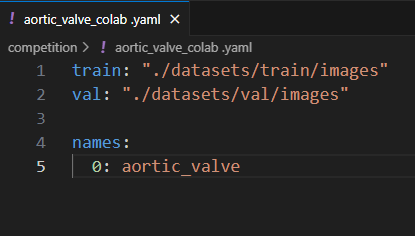



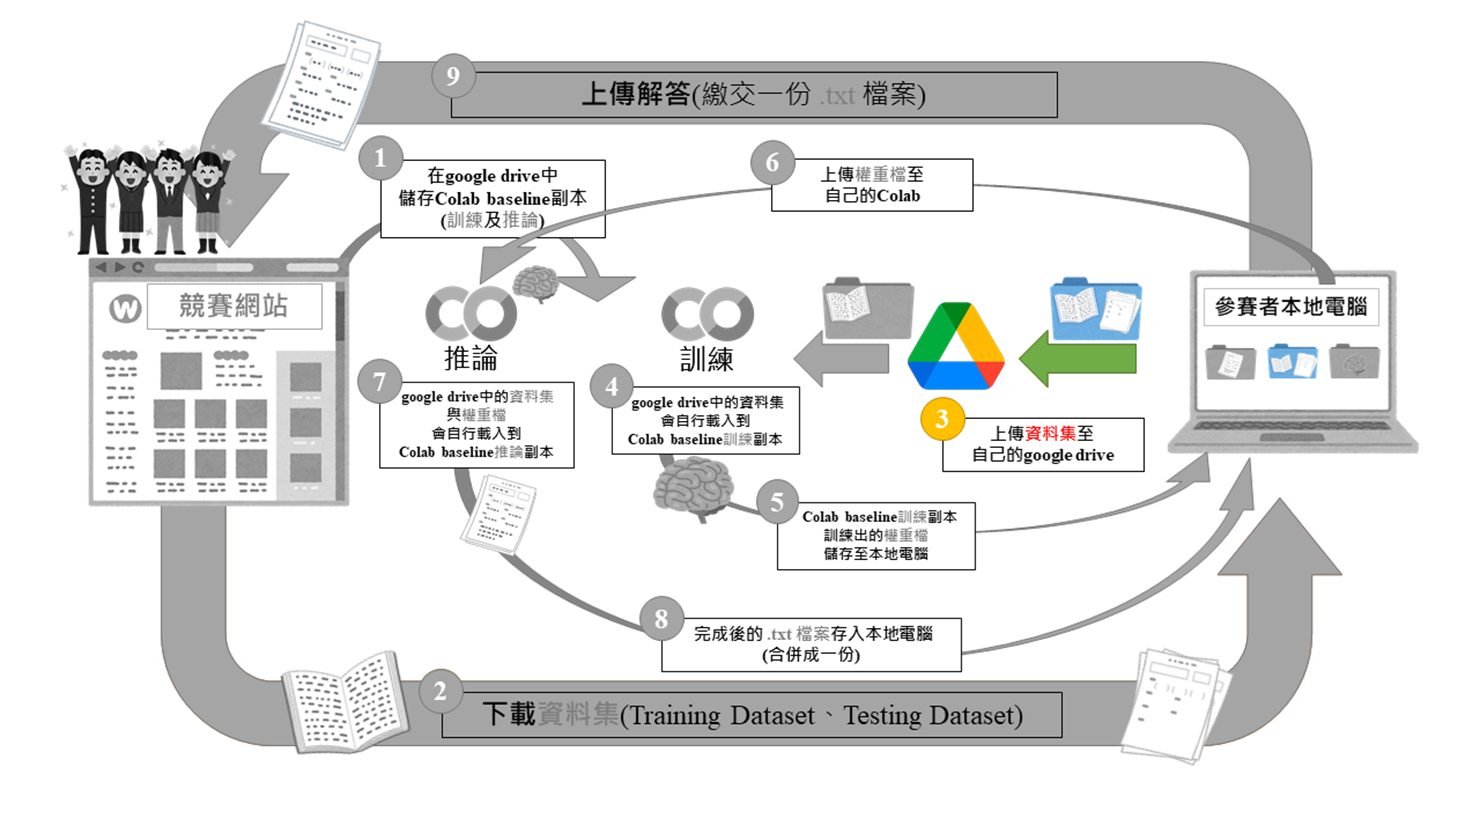

上傳資料集


將training_image.zip、training_label.zip和aortic_valve_colab.yaml上傳至個人的Google雲端硬碟


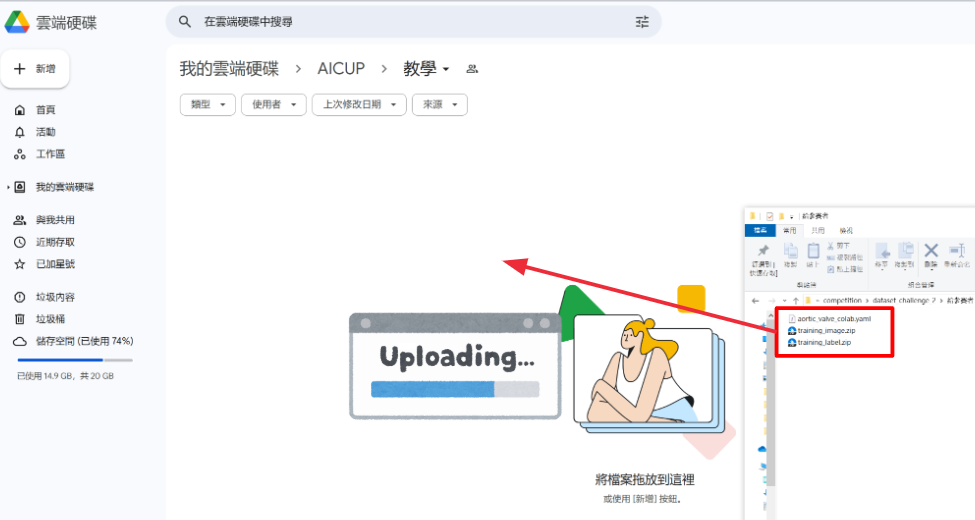

更改檔案權限(training_image.zip、training_label.zip和aortic_valve_colab.yaml**三個檔案權限都要更改**) image.png

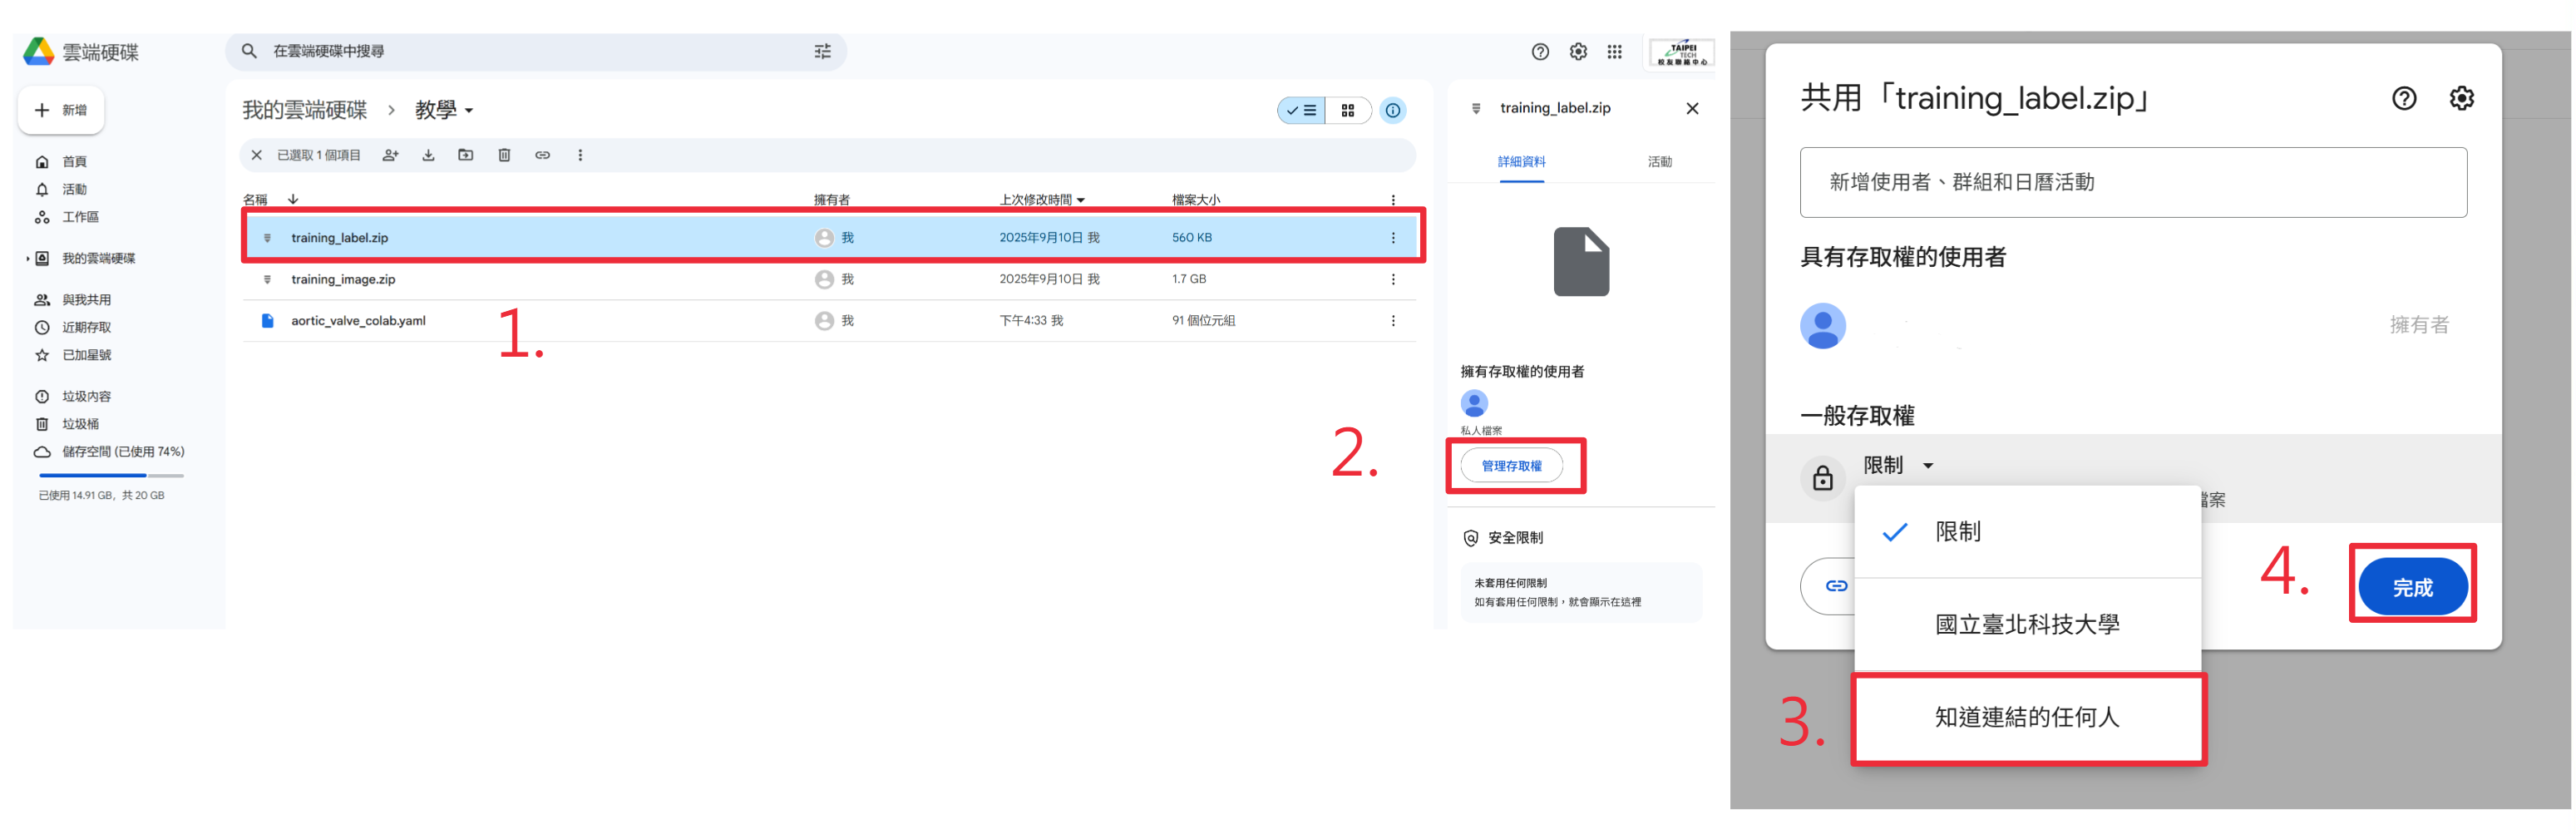

取得雲端資料下載連結(下方程式需要用到)
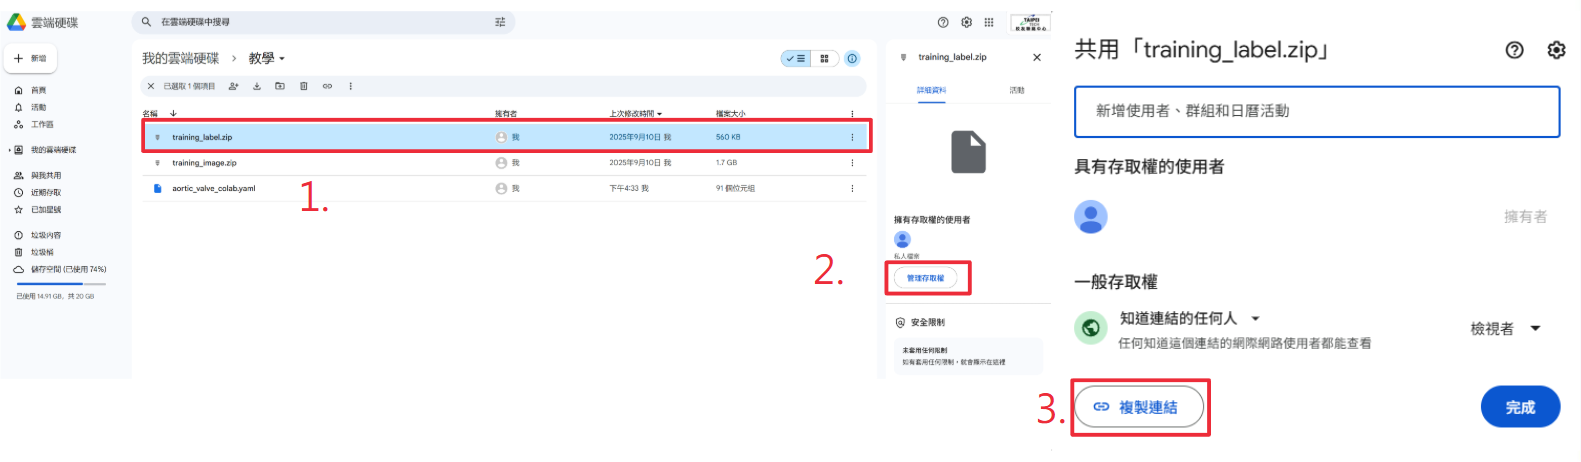

將剛剛取得的網址透過下方網址轉換成直接下載的格式


https://sites.google.com/view/twdrivefromdownload/%E7%B9%81%E9%AB%94%E4%B8%AD%E6%96%87traditional-chinese?authuser=0

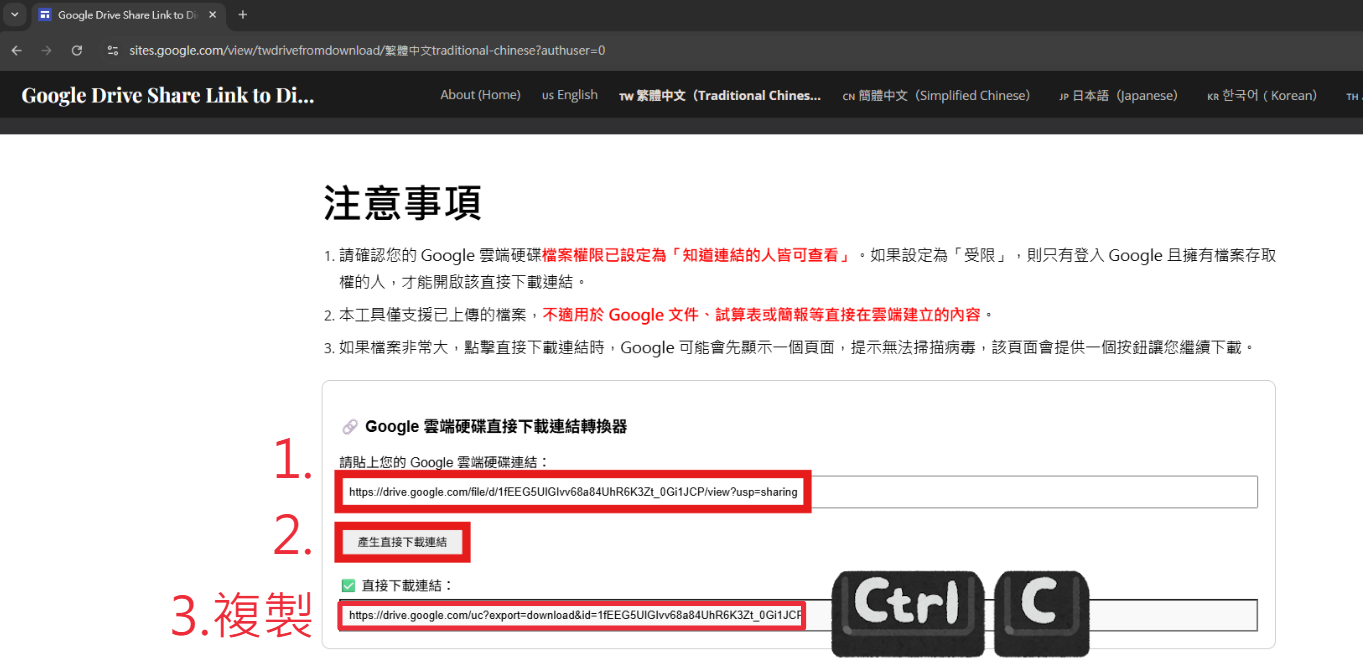

#=====================================================

#BLOCK 4

#透過上面方法更改下方程式的三個網址(執行時間<1分鐘) image.png



 *請自行上傳雲端替換成自己的連結，此範例連結雖然與最初競賽資料集相同，但不保證會更新且隨時有可能會刪除!!!

#=====================================================

In [4]:
#下載資料集
import gdown
import os
import shutil

#下載training_image.zip
gdown.download("https://drive.google.com/uc?export=download&id=1RP1w3lg4CJIl1C8_79M8BHYSiqcMej6R","/content/training_image.zip")
#下載training_label.zip
gdown.download("https://drive.google.com/uc?export=download&id=1v4yfl4UprQjCNgMI7ZKWN0iD6t9ASibG","/content/training_label.zip")
#下載訓練aortic_valve_colab.yaml
gdown.download("https://drive.google.com/u/0/uc?id=1OyGJ7mfVLutjkE55U9wfs4bmHCtIN1cv&export=download","/content/aortic_valve_colab.yaml")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1RP1w3lg4CJIl1C8_79M8BHYSiqcMej6R
From (redirected): https://drive.google.com/uc?export=download&id=1RP1w3lg4CJIl1C8_79M8BHYSiqcMej6R&confirm=t&uuid=4297bda3-6d86-4368-a692-6e4a2a930f10
To: /content/training_image.zip
100%|██████████| 1.83G/1.83G [00:25<00:00, 70.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1v4yfl4UprQjCNgMI7ZKWN0iD6t9ASibG
To: /content/training_label.zip
100%|██████████| 659k/659k [00:00<00:00, 85.0MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1OyGJ7mfVLutjkE55U9wfs4bmHCtIN1cv&export=download
To: /content/aortic_valve_colab.yaml
100%|██████████| 91.0/91.0 [00:00<00:00, 406kB/s]


'/content/aortic_valve_colab.yaml'

#=====================================================

#BLOCK 5

#移動檔案(透過下方程式，執行時間<1分鐘)


#此範例將前30筆資料用於訓練，後20筆資料用於驗證，參賽者可在程式中53行及56行更改比例

#因為Colab運算資源有限此處只採用有標註檔的圖片，其餘圖片也可以自行修改程式利用

將前30筆資料的圖片全部移動至./datasets/train/images，


 前30筆資料的標註全部移動至./datasets/train/labels，


 後20筆資料的圖片全部移動至./datasets/val/images，


 後20筆資料的標註全部移動至./datasets/val/labels。


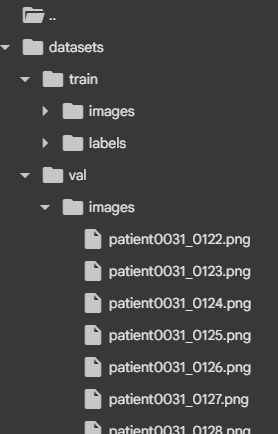

#=====================================================

In [5]:
import os, shutil

def find_patient_root(root):
    """往下找，直到找到含有 patientXXXX 的資料夾"""
    for dirpath, dirnames, filenames in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root  # fallback

# 解壓縮到固定資料夾
if not os.path.isdir("./training_image") and os.path.exists("training_image.zip"):
    os.makedirs("./training_image", exist_ok=True)
    !unzip -q training_image.zip -d ./training_image

if not os.path.isdir("./training_label") and os.path.exists("training_label.zip"):
    os.makedirs("./training_label", exist_ok=True)
    !unzip -q training_label.zip -d ./training_label

IMG_ROOT = find_patient_root("./training_image")
LBL_ROOT = find_patient_root("./training_label")

print("IMG_ROOT =", IMG_ROOT)
print("LBL_ROOT =", LBL_ROOT)

# 建立並清空輸出資料夾（若存在）
def ensure_clean_dir(path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

# 5:4:1 => train/val/test
ensure_clean_dir("./datasets/train/images")
ensure_clean_dir("./datasets/train/labels")
ensure_clean_dir("./datasets/val/images")
ensure_clean_dir("./datasets/val/labels")
ensure_clean_dir("./datasets/test/images")
ensure_clean_dir("./datasets/test/labels")

def get_available_patients():
    """找出真正有 label 資料夾的 patient 清單"""
    patients = []
    # 從 label root 找，避免有影像但沒標註
    for d in sorted(os.listdir(LBL_ROOT)):
        if d.startswith("patient") and os.path.isdir(os.path.join(LBL_ROOT, d)):
            patients.append(d)
    return patients

def copy_one_patient(patient, split):
    img_dir = os.path.join(IMG_ROOT, patient)
    lbl_dir = os.path.join(LBL_ROOT, patient)
    if not os.path.isdir(lbl_dir):
        return

    for fname in os.listdir(lbl_dir):
        if not fname.endswith(".txt"):
            continue

        label_path = os.path.join(lbl_dir, fname)
        base, _ = os.path.splitext(fname)
        img_path = os.path.join(img_dir, base + ".png")

        if not os.path.exists(img_path):
            print(f"找不到對應圖片: {img_path}")
            continue

        shutil.copy2(img_path, f"./datasets/{split}/images/")
        shutil.copy2(label_path, f"./datasets/{split}/labels/")

patients = get_available_patients()
n = len(patients)

# 5:4:1 切分（用 floor，最後剩下的都丟 test）
n_train = int(n * 0.5)
n_val   = int(n * 0.4)
n_test  = n - n_train - n_val

train_patients = patients[:n_train]
val_patients   = patients[n_train:n_train + n_val]
test_patients  = patients[n_train + n_val:]

print(f"總病人數={n} | train={len(train_patients)} | val={len(val_patients)} | test={len(test_patients)}")

for p in train_patients:
    copy_one_patient(p, "train")
for p in val_patients:
    copy_one_patient(p, "val")
for p in test_patients:
    copy_one_patient(p, "test")

print("完成移動！")
print('訓練集圖片數量 : ',len(os.listdir("./datasets/train/images")))
print('訓練集標記數量 : ',len(os.listdir("./datasets/train/labels")))
print('驗證集圖片數量 : ',len(os.listdir("./datasets/val/images")))
print('驗證集標記數量 : ',len(os.listdir("./datasets/val/labels")))
print('驗證集圖片數量 : ',len(os.listdir("./datasets/test/images")))
print('驗證集標記數量 : ',len(os.listdir("./datasets/test/labels")))

IMG_ROOT = ./training_image/training_image
LBL_ROOT = ./training_label/training_label
總病人數=50 | train=25 | val=20 | test=5
完成移動！
訓練集圖片數量 :  1396
訓練集標記數量 :  1396
驗證集圖片數量 :  1064
驗證集標記數量 :  1064
驗證集圖片數量 :  327
驗證集標記數量 :  327


=== Counts ===
train_images: 1396
val_images  : 1064
test_images : 327
train_labels: 1396
val_labels  : 1064
test_labels : 327


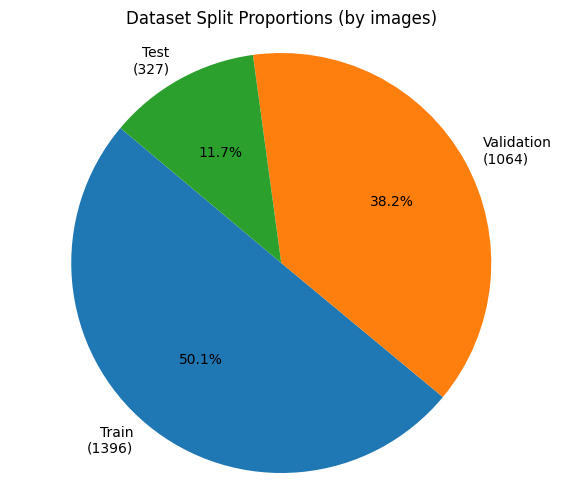

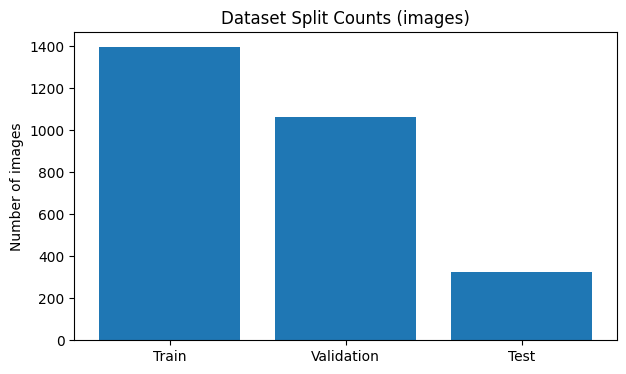


images vs labels: [1396, 1064, 327] vs [1396, 1064, 327]


In [6]:
import os
import matplotlib.pyplot as plt

def safe_count(dirpath):
    """資料夾不存在就回傳 0；存在就回傳檔案數（不含子資料夾）"""
    if not os.path.isdir(dirpath):
        return 0
    return sum(1 for f in os.listdir(dirpath) if os.path.isfile(os.path.join(dirpath, f)))

# 你切割後的資料夾
paths = {
    "train_images": "./datasets/train/images",
    "val_images":   "./datasets/val/images",
    "test_images":  "./datasets/test/images",
    "train_labels": "./datasets/train/labels",
    "val_labels":   "./datasets/val/labels",
    "test_labels":  "./datasets/test/labels",
}

counts = {k: safe_count(v) for k, v in paths.items()}

print("=== Counts ===")
for k, v in counts.items():
    print(f"{k:12s}: {v}")

# 以 images 的數量做比例圖（最常用）
labels = ["Train", "Validation", "Test"]
sizes  = [counts["train_images"], counts["val_images"], counts["test_images"]]

total = sum(sizes)
if total == 0:
    raise ValueError("datasets 資料夾看起來是空的（images=0）。請確認你有先跑完切割程式，且路徑是 ./datasets/...")

plt.figure(figsize=(7, 6))
plt.pie(
    sizes,
    labels=[f"{lab}\n({sz})" for lab, sz in zip(labels, sizes)],
    autopct=lambda p: f"{p:.1f}%",
    startangle=140
)
plt.title("Dataset Split Proportions (by images)")
plt.axis("equal")
plt.show()

# （可選）再畫一張長條圖：更直觀比較數量
plt.figure(figsize=(7, 4))
plt.bar(labels, sizes)
plt.title("Dataset Split Counts (images)")
plt.ylabel("Number of images")
plt.show()

# （可選）如果你也想確認 labels 是否和 images 一致：
lbl_sizes = [counts["train_labels"], counts["val_labels"], counts["test_labels"]]
print("\nimages vs labels:", sizes, "vs", lbl_sizes)


#=====================================================

#BLOCK 6

#確認檔案是否成功移動 image.png

#如果資料數量符合下圖數量代表移動成功

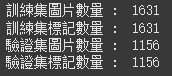

#=====================================================

In [ ]:
!ls

aortic_valve_colab.yaml  training_image      training_label
datasets		 training_image.zip  training_label.zip


#### 3. 訓練模型(運行時間約15分鐘)

#=====================================================

#BLOCK 7

#執行後依序有Epoch在跑代表成功

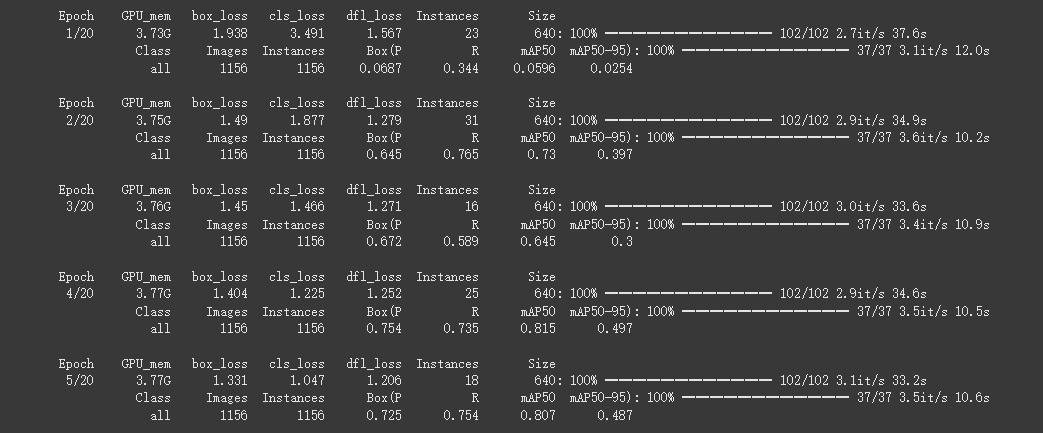

#=====================================================

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
from ultralytics import YOLO

# 用 YOLOv9c（推薦），可換成你自己的 best.pt 微調
model = YOLO("yolov9m.pt")

results = model.train(
    data="./aortic_valve_colab.yaml",
    epochs=70,
    batch=8,          # T4 建議從 8 起跳
    imgsz=640,
    device=0,
    patience=12,

    # ✅ 省顯存、醫學影像合理的 augmentation
    mosaic=0.05,      # 0.0~0.1
    mixup=0.0,        # ❌ 關掉（很吃）
    copy_paste=0.0,   # ❌ 關掉（很吃）
    fliplr=0.5,
    flipud=0.2,       # 醫學影像別太高
    scale=0.4,
    hsv_h=0.01,
    hsv_s=0.3,
    hsv_v=0.3,

    # ✅ 建議先不要亂拉 loss 權重（你那組 box/cls/dfl 很激進）
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # optimizer 先用預設 auto（比較穩）
    lr0=0.003,
    momentum=0.945,

    workers=2,        # ✅ T4 建議 2（8 會炸 RAM/顯存也會更緊）
    amp=False,        # ✅ 你環境會觸發內部 import 問題，先關最穩
    compile=False,
)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./aortic_valve_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.2, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.3, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9m.pt, momentum=0.945, mosaic=0.05, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=12, perspective=0.0, plots=True, pose=12.0, 

KeyboardInterrupt: 

#訓練完左方檔案會有run資料夾，此份Colab主要目標是得到best.pt用於下一份Colab進行預測image.png

(!!如果有重複訓練**請下載最後成功**的train編號資料夾)

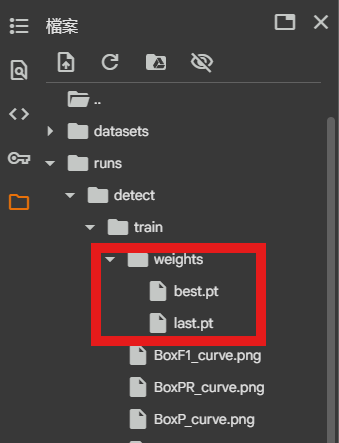

#### 4. 壓縮並下載訓練完的模型

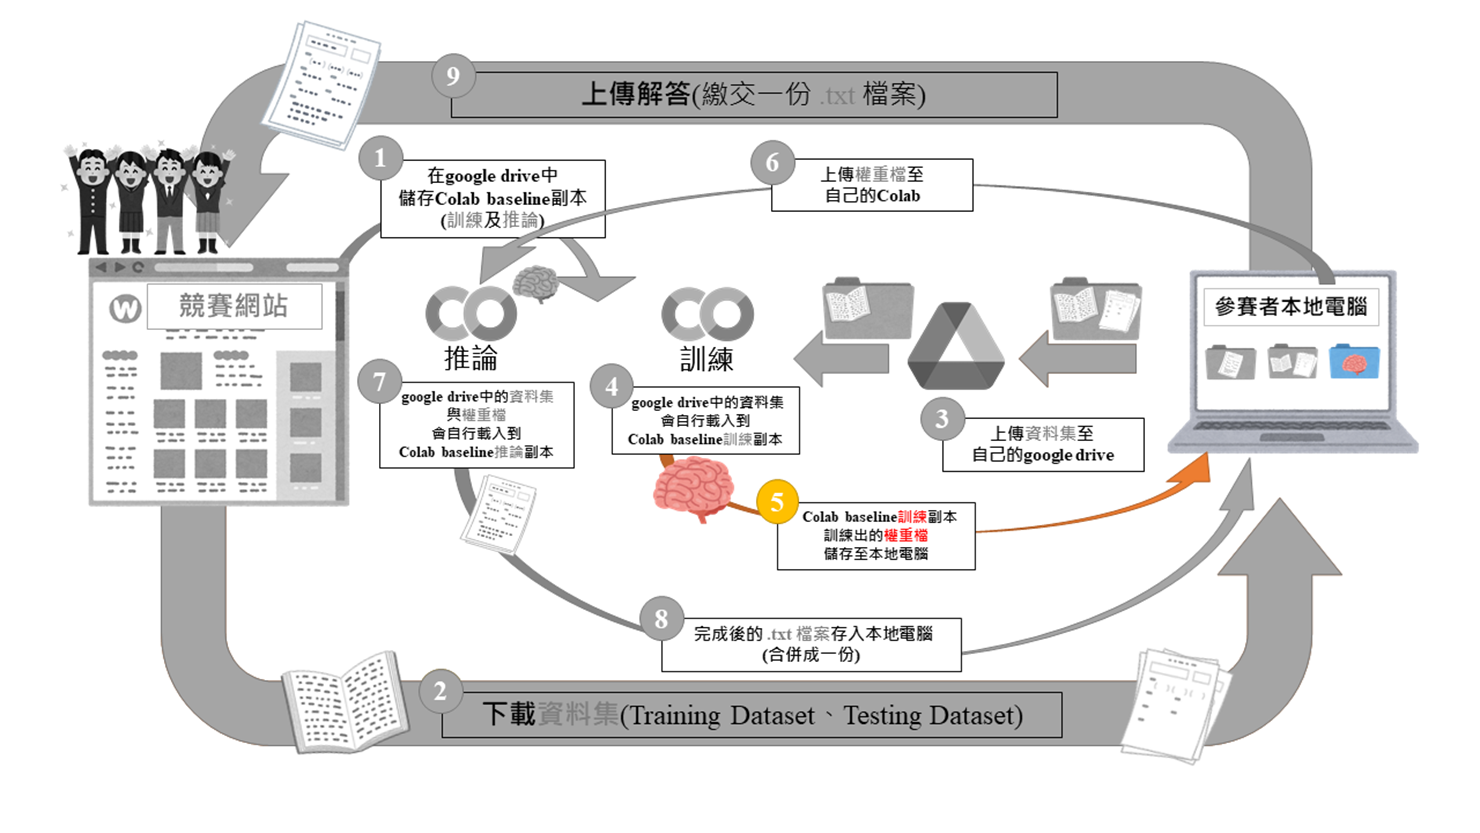

#=====================================================

#BLOCK 8

#下載訓練完的模型權重

#確認下方進度條消失才有下載成功 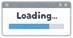

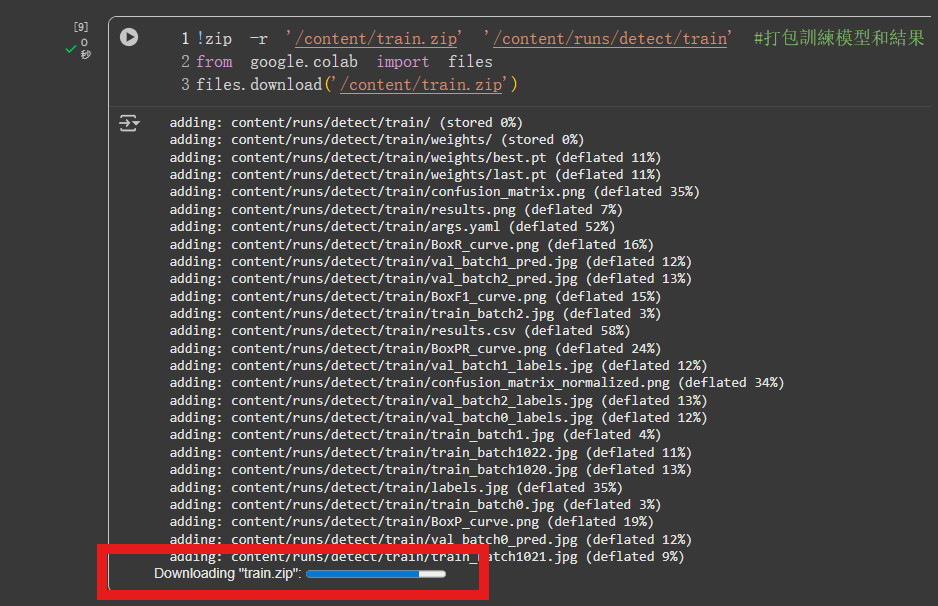

#=====================================================

In [ ]:
!zip -r '/content/train.zip' '/content/runs/detect/train' #打包訓練模型和結果
from google.colab import files
files.download('/content/train.zip')

  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/best.pt (deflated 11%)
  adding: content/runs/detect/train/weights/last.pt (deflated 11%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 35%)
  adding: content/runs/detect/train/results.png (deflated 7%)
  adding: content/runs/detect/train/args.yaml (deflated 52%)
  adding: content/runs/detect/train/BoxR_curve.png (deflated 16%)
  adding: content/runs/detect/train/val_batch1_pred.jpg (deflated 12%)
  adding: content/runs/detect/train/val_batch2_pred.jpg (deflated 13%)
  adding: content/runs/detect/train/BoxF1_curve.png (deflated 15%)
  adding: content/runs/detect/train/train_batch2.jpg (deflated 3%)
  adding: content/runs/detect/train/results.csv (deflated 58%)
  adding: content/runs/detect/train/BoxPR_curve.png (deflated 24%)
  adding: content/runs/detect/train/val_batch1_labels.jpg (deflated 12%)
  adding: content/ru

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

也可以右鍵直接下載best.pt和last.pt image.png

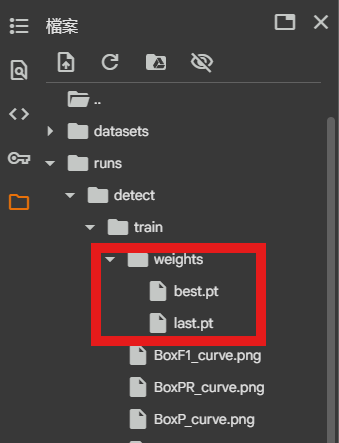

#=====================================================

#BLOCK 9.1

#接續上次訓練的模型繼續訓練

#需先將上次訓練到的best.pt上傳至左邊檔案區

#*如果為初次訓練則不用跑此BLOCK

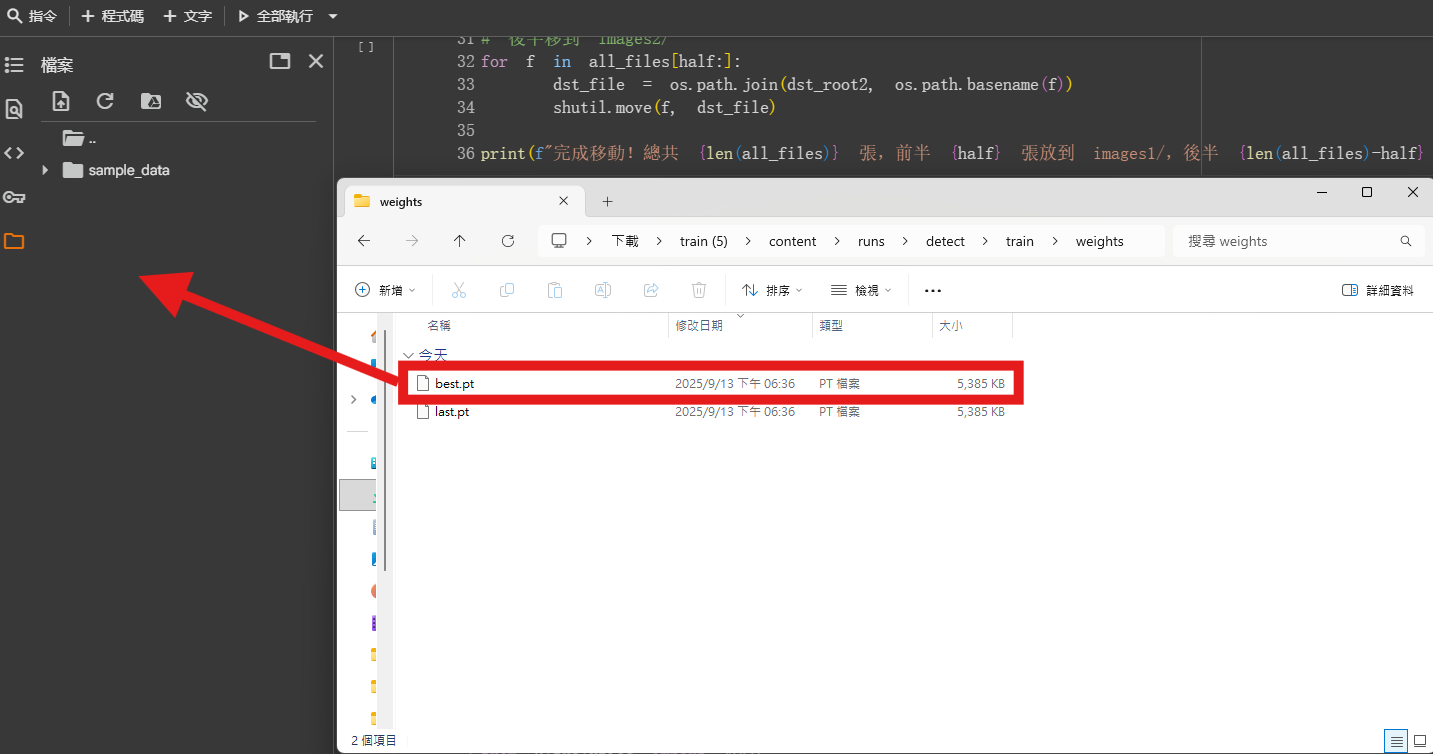

#訓練第二次會有train2資料夾

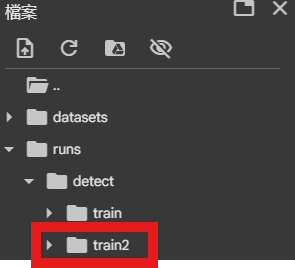

#=====================================================

In [ ]:
from ultralytics import YOLO

model = YOLO('best.pt') #將模型改成'best.pt'或其他訓練過的模型名稱

results = model.train(
data="./aortic_valve_colab.yaml",
    epochs=20,
    batch=8,          # T4 建議從 8 起跳
    imgsz=640,
    device=0,
    patience=12,

    # ✅ 省顯存、醫學影像合理的 augmentation
    mosaic=0.05,      # 0.0~0.1
    mixup=0.0,        # ❌ 關掉（很吃）
    copy_paste=0.0,   # ❌ 關掉（很吃）
    fliplr=0.5,
    flipud=0.2,       # 醫學影像別太高
    scale=0.4,
    hsv_h=0.01,
    hsv_s=0.3,
    hsv_v=0.3,

    # ✅ 建議先不要亂拉 loss 權重（你那組 box/cls/dfl 很激進）
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # optimizer 先用預設 auto（比較穩）
    lr0=0.003,
    momentum=0.945,

    workers=2,        # ✅ T4 建議 2（8 會炸 RAM/顯存也會更緊）
    amp=False,        # ✅ 你環境會觸發內部 import 問題，先關最穩
    compile=False,
)


Ultralytics 8.3.217 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./aortic_valve_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

#=====================================================

#BLOCK 9.2

#接續上次訓練的模型繼續訓練

#需先將上次訓練的整個train資料夾上傳至雲端再載入Colab

#*如果為初次訓練則不用跑此BLOCK

載入上次的訓練

In [ ]:
#從雲端下載上次訓練的 train 資料夾 並移動到 runs 底下
import gdown
import os
gdown.download("https://drive.google.com/uc?export=download&id=1DJRlpA_cIgmoCGMrr6nqjk78VINS7P4G","/content/train.zip")
!unzip -q train.zip -d .
!mv content/runs ./runs
!rm -r content

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1DJRlpA_cIgmoCGMrr6nqjk78VINS7P4G
From (redirected): https://drive.google.com/uc?export=download&id=1DJRlpA_cIgmoCGMrr6nqjk78VINS7P4G&confirm=t&uuid=cc72460e-4106-4aca-8681-ea3fee7e6b57
To: /content/train.zip
100%|██████████| 21.9M/21.9M [00:00<00:00, 23.3MB/s]


第二次訓練

resume變數只能接續跑完上次訓練沒跑完的Epochs

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train/weights/last.pt') #將模型改成'best.pt'或其他訓練過的模型名稱
results = model.train(data="./aortic_valve_colab.yaml",
            resume = True
            )

New https://pypi.org/project/ultralytics/8.3.225 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./aortic_valve_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/runs/detect/train/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nb

KeyboardInterrupt: 

下載第二次訓練

In [ ]:
!zip -r '/content/train.zip' '/content/runs/detect/train' #打包訓練模型和結果
from google.colab import files
files.download('/content/train.zip')

updating: content/runs/detect/train/ (stored 0%)
updating: content/runs/detect/train/train_batch2.jpg (deflated 4%)
updating: content/runs/detect/train/weights/ (stored 0%)
updating: content/runs/detect/train/weights/last.pt (deflated 12%)
updating: content/runs/detect/train/weights/best.pt (deflated 12%)
updating: content/runs/detect/train/labels.jpg (deflated 35%)
updating: content/runs/detect/train/args.yaml (deflated 54%)
updating: content/runs/detect/train/train_batch1.jpg (deflated 5%)
updating: content/runs/detect/train/results.csv (deflated 61%)
updating: content/runs/detect/train/train_batch0.jpg (deflated 3%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# test&loU 測試訓練模型

In [8]:
import os
print(os.path.isdir("/content/datasets/train/images"))
print(os.path.isdir("/content/datasets/val/images"))
print(os.path.isdir("/content/datasets/test/images"))
from pathlib import Path

yaml_text = """\
path: /content/datasets

train: train/images
val: val/images
test: test/images

nc: 1
names:
  0: aortic_valve
"""

Path("aortic_valve_colab.yaml").write_text(yaml_text, encoding="utf-8")
print("✅ YAML updated")
print(Path("aortic_valve_colab.yaml").read_text())

from ultralytics.models.yolo.model import YOLO

best = YOLO("/content/best_9m_110.pt")

test_metrics = best.val(
    data="./aortic_valve_colab.yaml",
    split="test",     # ✅ 用 test
    imgsz=512,
    device=0
)

# Precision / Recall
P = test_metrics.box.mp      # mean precision
R = test_metrics.box.mr      # mean recall

# mAP
mAP50 = test_metrics.box.map50
mAP5095 = test_metrics.box.map

print(f"Precision (P)      = {P:.3f}")
print(f"Recall (R)         = {R:.3f}")
print(f"mAP@0.50           = {mAP50:.3f}")
print(f"mAP@0.50:0.95      = {mAP5095:.3f}")
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import glob
import numpy as np
import torch

# 你的模型
best = YOLO("/content/best_9m_110.pt")

TEST_IMG_DIR = Path("/content/datasets/test/images")
TEST_LBL_DIR = Path("/content/datasets/test/labels")

# 支援常見副檔名
img_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tif", "*.tiff", "*.webp"):
    img_paths += glob.glob(str(TEST_IMG_DIR / ext))
img_paths = sorted(img_paths)

def xywhn_to_xyxy_pixels(xywhn, w, h):
    # xywhn: normalized [x_center, y_center, width, height]
    x, y, bw, bh = xywhn
    x1 = (x - bw/2) * w
    y1 = (y - bh/2) * h
    x2 = (x + bw/2) * w
    y2 = (y + bh/2) * h
    return np.array([x1, y1, x2, y2], dtype=np.float32)

def iou_xyxy(a, b):
    # a,b: [x1,y1,x2,y2]
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    interW = max(0.0, xB - xA)
    interH = max(0.0, yB - yA)
    inter = interW * interH
    areaA = max(0.0, a[2]-a[0]) * max(0.0, a[3]-a[1])
    areaB = max(0.0, b[2]-b[0]) * max(0.0, b[3]-b[1])
    union = areaA + areaB - inter + 1e-9
    return inter / union

ious = []
skipped_no_pred = 0
skipped_no_gt = 0

for ip in img_paths:
    ip = Path(ip)
    stem = ip.stem
    lp = TEST_LBL_DIR / f"{stem}.txt"
    if not lp.exists():
        skipped_no_gt += 1
        continue

    # 讀圖片尺寸
    w, h = Image.open(ip).size

    # 讀 GT（你是 nc=1 且每張 1 個框，取第一行）
    line = lp.read_text().strip().splitlines()
    if len(line) == 0:
        skipped_no_gt += 1
        continue

    parts = line[0].split()
    # YOLO label: cls x y w h (normalized)
    xywhn = list(map(float, parts[1:5]))
    gt = xywhn_to_xyxy_pixels(xywhn, w, h)

    # 預測（取 conf 最高的框）
    r = best.predict(source=str(ip), imgsz=512, device=0, verbose=False)[0]
    if r.boxes is None or len(r.boxes) == 0:
        skipped_no_pred += 1
        continue

    conf = r.boxes.conf.detach().cpu().numpy()
    xyxy = r.boxes.xyxy.detach().cpu().numpy()
    best_idx = int(conf.argmax())
    pred = xyxy[best_idx]

    ious.append(iou_xyxy(pred, gt))

mean_iou = float(np.mean(ious)) if len(ious) else float("nan")
print(f"Mean IoU = {mean_iou:.3f}")
print(f"used={len(ious)} | skip_no_pred={skipped_no_pred} | skip_no_gt={skipped_no_gt}")


True
True
True
✅ YAML updated
path: /content/datasets

train: train/images
val: val/images
test: test/images

nc: 1
names:
  0: aortic_valve

Ultralytics 8.3.243 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9m summary (fused): 151 layers, 20,013,715 parameters, 0 gradients, 76.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2316.0±276.1 MB/s, size: 110.3 KB)
val: Scanning /content/datasets/test/labels.cache... 327 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 327/327 612.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 3.1it/s 6.9s
                   all        327        327      0.898       0.94      0.945      0.624
Speed: 1.5ms preprocess, 15.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs/detect/val2
Precision (P)      = 0.898
Recall (R)         = 0.940
mAP@0.50           = 0.945
mAP@0.50:0.95      = 0.624
Mean IoU = 0.776
used=

有效樣本 used=325 | skip_no_pred=2 | skip_no_gt=0
Mean IoU=0.776 | Median IoU=0.829


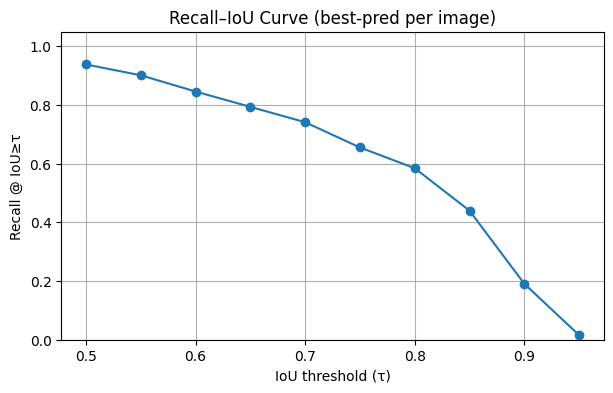

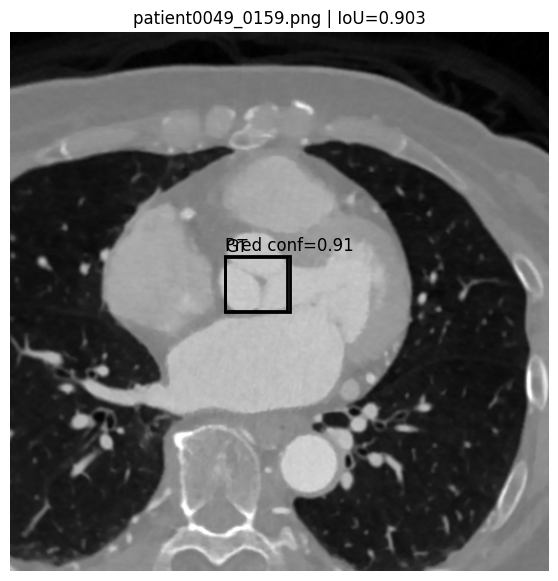

In [9]:
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import glob, random
import numpy as np
import matplotlib.pyplot as plt

best = YOLO("/content/best_9m_110.pt")

TEST_IMG_DIR = Path("/content/datasets/test/images")
TEST_LBL_DIR = Path("/content/datasets/test/labels")

# 支援常見副檔名
img_paths = []
for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp"):
    img_paths += glob.glob(str(TEST_IMG_DIR / ext))
img_paths = sorted(map(Path, img_paths))

def xywhn_to_xyxy_pixels(xywhn, w, h):
    x, y, bw, bh = xywhn
    x1 = (x - bw/2) * w
    y1 = (y - bh/2) * h
    x2 = (x + bw/2) * w
    y2 = (y + bh/2) * h
    return np.array([x1, y1, x2, y2], dtype=np.float32)

def iou_xyxy(a, b):
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    interW = max(0.0, xB - xA)
    interH = max(0.0, yB - yA)
    inter = interW * interH
    areaA = max(0.0, a[2]-a[0]) * max(0.0, a[3]-a[1])
    areaB = max(0.0, b[2]-b[0]) * max(0.0, b[3]-b[1])
    union = areaA + areaB - inter + 1e-9
    return inter / union

# 1) 先把每張的 IoU、conf、框存起來（只取 conf 最高的那個 pred）
records = []
skip_no_gt = 0
skip_no_pred = 0

for ip in img_paths:
    lp = TEST_LBL_DIR / f"{ip.stem}.txt"
    if not lp.exists():
        skip_no_gt += 1
        continue

    # 讀 GT（取第一個框；若你每張可能多框，可再擴充）
    lines = lp.read_text().strip().splitlines()
    if len(lines) == 0:
        skip_no_gt += 1
        continue

    w, h = Image.open(ip).size
    parts = lines[0].split()
    xywhn = list(map(float, parts[1:5]))
    gt_xyxy = xywhn_to_xyxy_pixels(xywhn, w, h)

    # 預測
    r = best.predict(source=str(ip), imgsz=512, device=0, verbose=False)[0]
    if r.boxes is None or len(r.boxes) == 0:
        skip_no_pred += 1
        continue

    confs = r.boxes.conf.detach().cpu().numpy()
    preds = r.boxes.xyxy.detach().cpu().numpy()
    best_idx = int(confs.argmax())
    pred_xyxy = preds[best_idx]
    conf = float(confs[best_idx])

    iou = float(iou_xyxy(pred_xyxy, gt_xyxy))

    records.append({
        "img": ip,
        "gt": gt_xyxy,
        "pred": pred_xyxy,
        "conf": conf,
        "iou": iou,
        "w": w, "h": h
    })

ious = np.array([r["iou"] for r in records], dtype=np.float32)
print(f"有效樣本 used={len(records)} | skip_no_pred={skip_no_pred} | skip_no_gt={skip_no_gt}")
print(f"Mean IoU={float(np.mean(ious)):.3f} | Median IoU={float(np.median(ious)):.3f}")

# 2) 用 IoU 門檻畫 Recall 曲線：Recall@IoU=τ
taus = np.round(np.arange(0.50, 0.96, 0.05), 2)  # 0.50~0.95
recalls = [(ious >= t).mean() for t in taus]

plt.figure(figsize=(7,4))
plt.plot(taus, recalls, marker="o")
plt.ylim(0, 1.05)
plt.xlabel("IoU threshold (τ)")
plt.ylabel("Recall @ IoU≥τ")
plt.title("Recall–IoU Curve (best-pred per image)")
plt.grid(True)
plt.show()

# 3) 隨機挑一張：畫 GT vs Pred 框並顯示 IoU/conf
if len(records) > 0:
    sample = random.choice(records)
    img = Image.open(sample["img"]).convert("RGB")
    arr = np.array(img)

    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(arr)

    # 畫 GT
    gx1, gy1, gx2, gy2 = sample["gt"]
    ax.add_patch(plt.Rectangle((gx1, gy1), gx2-gx1, gy2-gy1, fill=False, linewidth=2))
    ax.text(gx1, max(0, gy1-5), "GT", fontsize=12)

    # 畫 Pred
    px1, py1, px2, py2 = sample["pred"]
    ax.add_patch(plt.Rectangle((px1, py1), px2-px1, py2-py1, fill=False, linewidth=2))
    ax.text(px1, max(0, py1-5), f"Pred conf={sample['conf']:.2f}", fontsize=12)

    ax.set_title(f"{sample['img'].name} | IoU={sample['iou']:.3f}")
    ax.axis("off")
    plt.show()
else:
    print("records 為空：請確認 test/images、test/labels 路徑與內容。")


GT boxes total = 327
Pred boxes total = 348
IoU threshold = 0.5
AP (trapz)    = 0.9191
Final P       = 0.8879
Final R       = 0.9450


/tmp/ipython-input-651317058.py:152: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = float(np.trapz(precision, recall))


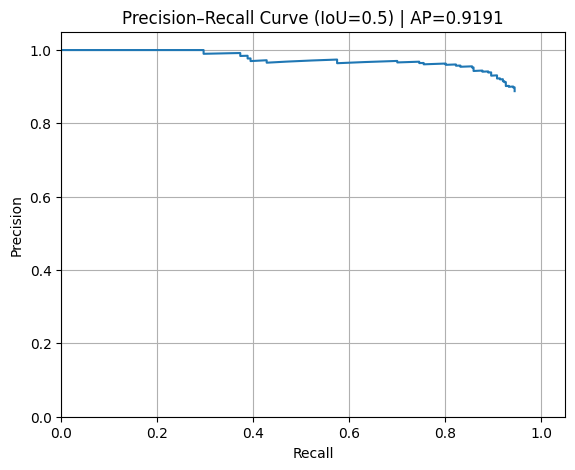

Best F1=0.9210 at conf≈0.375, P=0.8983, R=0.9450


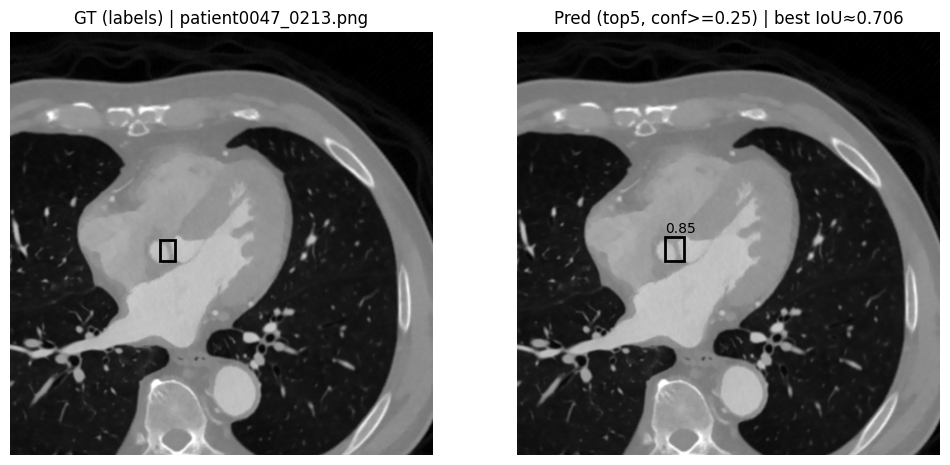

In [10]:
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import glob, random
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 設定
# =========================
MODEL_PATH = "/content/best_9m_110.pt"
TEST_IMG_DIR = Path("/content/datasets/test/images")
TEST_LBL_DIR = Path("/content/datasets/test/labels")

IMG_EXTS = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp")
IOU_THR = 0.50       # 經典 mAP@0.5 / PR curve 通常固定 IoU=0.5
IMGSZ = 512
DEVICE = 0

# 若你想掃 COCO 標準（0.5~0.95），等你先把 PR@0.5 跑起來我再幫你擴充


# =========================
# 基本工具
# =========================
def list_images(img_dir: Path):
    paths = []
    for ext in IMG_EXTS:
        paths += glob.glob(str(img_dir / ext))
    return sorted(map(Path, paths))

def read_yolo_labels(label_path: Path):
    """
    回傳 list of (cls, x, y, w, h) in normalized format
    """
    if not label_path.exists():
        return []
    lines = label_path.read_text().strip().splitlines()
    out = []
    for ln in lines:
        if not ln.strip():
            continue
        p = ln.split()
        if len(p) < 5:
            continue
        cls = int(float(p[0]))
        x, y, w, h = map(float, p[1:5])
        out.append((cls, x, y, w, h))
    return out

def xywhn_to_xyxy_pixels(xywhn, W, H):
    x, y, bw, bh = xywhn
    x1 = (x - bw/2) * W
    y1 = (y - bh/2) * H
    x2 = (x + bw/2) * W
    y2 = (y + bh/2) * H
    return np.array([x1, y1, x2, y2], dtype=np.float32)

def iou_xyxy(a, b):
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    interW = max(0.0, xB - xA)
    interH = max(0.0, yB - yA)
    inter = interW * interH
    areaA = max(0.0, a[2]-a[0]) * max(0.0, a[3]-a[1])
    areaB = max(0.0, b[2]-b[0]) * max(0.0, b[3]-b[1])
    union = areaA + areaB - inter + 1e-9
    return inter / union


# =========================
# 1) 蒐集 GT 與 Pred（全 test）
# =========================
best = YOLO(MODEL_PATH)
img_paths = list_images(TEST_IMG_DIR)

# GT: 每張圖可能有多個框（更嚴謹）
gt_by_img = {}  # img_name -> list of gt boxes (xyxy)
n_gt_total = 0

for ip in img_paths:
    lp = TEST_LBL_DIR / f"{ip.stem}.txt"
    gts_norm = read_yolo_labels(lp)
    if len(gts_norm) == 0:
        gt_by_img[ip.name] = []
        continue
    W, H = Image.open(ip).size
    gts_xyxy = []
    for (cls, x, y, w, h) in gts_norm:
        # 你是 nc=1，cls 不用分開算；若要分 class 再擴充
        gts_xyxy.append(xywhn_to_xyxy_pixels((x,y,w,h), W, H))
    gt_by_img[ip.name] = gts_xyxy
    n_gt_total += len(gts_xyxy)

print(f"GT boxes total = {n_gt_total}")

# Pred: 蒐集所有預測框，並保留它屬於哪張圖（用於 matching）
preds_all = []  # list of dict: {img_name, conf, box_xyxy}
for ip in img_paths:
    r = best.predict(source=str(ip), imgsz=IMGSZ, device=DEVICE, verbose=False)[0]
    if r.boxes is None or len(r.boxes) == 0:
        continue
    confs = r.boxes.conf.detach().cpu().numpy()
    boxes = r.boxes.xyxy.detach().cpu().numpy()
    # classes = r.boxes.cls.detach().cpu().numpy()  # 若要分 class 再用
    for conf, box in zip(confs, boxes):
        preds_all.append({"img": ip.name, "conf": float(conf), "box": box.astype(np.float32)})

print(f"Pred boxes total = {len(preds_all)}")


# =========================
# 2) 經典 PR curve：按 conf 由大到小走訪，做 TP/FP matching
#    規則：同一張圖的每個 GT 只能被匹配一次（最常用的標準做法）
# =========================
preds_all.sort(key=lambda d: d["conf"], reverse=True)

# 記錄每張圖哪些 GT 已被配走
matched = {img_name: np.zeros(len(gt_by_img[img_name]), dtype=bool) for img_name in gt_by_img}

tp = np.zeros(len(preds_all), dtype=np.float32)
fp = np.zeros(len(preds_all), dtype=np.float32)

for i, pr in enumerate(preds_all):
    img_name = pr["img"]
    pred_box = pr["box"]
    gts = gt_by_img.get(img_name, [])

    if len(gts) == 0:
        fp[i] = 1.0
        continue

    # 找到此 pred 對所有 GT 的 IoU，挑「最高 IoU」的那個 GT
    ious = np.array([iou_xyxy(pred_box, gt) for gt in gts], dtype=np.float32)
    j = int(np.argmax(ious))
    best_iou = float(ious[j])

    if best_iou >= IOU_THR and (matched[img_name][j] == False):
        tp[i] = 1.0
        matched[img_name][j] = True
    else:
        fp[i] = 1.0

# 累積 TP/FP → Precision / Recall
tp_cum = np.cumsum(tp)
fp_cum = np.cumsum(fp)

precision = tp_cum / np.maximum(tp_cum + fp_cum, 1e-9)
recall = tp_cum / max(n_gt_total, 1e-9)

# AP（簡單 trapezoid；若要 COCO-style interpolation 也能做）
ap = float(np.trapz(precision, recall))

print(f"IoU threshold = {IOU_THR}")
print(f"AP (trapz)    = {ap:.4f}")
print(f"Final P       = {float(precision[-1]) if len(precision) else 0:.4f}")
print(f"Final R       = {float(recall[-1]) if len(recall) else 0:.4f}")

# 畫 PR curve（經典）
plt.figure(figsize=(6.5,5))
plt.plot(recall, precision)
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (IoU={IOU_THR}) | AP={ap:.4f}")
plt.grid(True)
plt.show()

# （可選）找最佳 F1 點（報告常用一句）
f1 = 2 * precision * recall / np.maximum(precision + recall, 1e-9)
best_idx = int(np.argmax(f1)) if len(f1) else -1
if best_idx >= 0:
    print(f"Best F1={float(f1[best_idx]):.4f} at conf≈{preds_all[best_idx]['conf']:.3f}, P={float(precision[best_idx]):.4f}, R={float(recall[best_idx]):.4f}")


# =========================
# 3) 隨機挑一張：Pred vs GT 疊框比較（左右並排）
# =========================
def draw_boxes(ax, img_arr, boxes, title, confs=None):
    ax.imshow(img_arr)
    ax.set_title(title)
    ax.axis("off")
    for k, b in enumerate(boxes):
        x1, y1, x2, y2 = b
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2)
        ax.add_patch(rect)
        if confs is not None:
            ax.text(x1, max(0, y1-5), f"{confs[k]:.2f}", fontsize=10)

# 挑一張「有 GT」的圖比較有意義
candidates = [ip for ip in img_paths if len(gt_by_img.get(ip.name, [])) > 0]
if len(candidates) == 0:
    print("找不到有 GT 的 test 圖，請確認 test/labels 是否正確。")
else:
    ip = random.choice(candidates)
    img = Image.open(ip).convert("RGB")
    img_arr = np.array(img)
    W, H = img.size

    # GT boxes
    gts = gt_by_img[ip.name]

    # Pred：取這張圖所有 pred（也可只取 top-k）
    r = best.predict(source=str(ip), imgsz=IMGSZ, device=DEVICE, verbose=False)[0]
    pred_boxes = []
    pred_confs = []
    if r.boxes is not None and len(r.boxes) > 0:
        confs = r.boxes.conf.detach().cpu().numpy()
        boxes = r.boxes.xyxy.detach().cpu().numpy()
        # 只保留 conf>=0.25（你可調），避免滿天框
        keep = confs >= 0.25
        boxes = boxes[keep]
        confs = confs[keep]
        # 依 conf 排序取前 5 個（避免太亂）
        order = np.argsort(-confs)[:5]
        pred_boxes = boxes[order].astype(np.float32).tolist()
        pred_confs = confs[order].astype(float).tolist()

    # 若你想看「最佳框的 IoU」
    best_iou = None
    if len(pred_boxes) > 0 and len(gts) > 0:
        # 以 conf 最高的 pred（pred_boxes[0]）對所有 GT 取最大 IoU
        pb = np.array(pred_boxes[0], dtype=np.float32)
        best_iou = float(max(iou_xyxy(pb, gt) for gt in gts))

    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    draw_boxes(axes[0], img_arr, gts, title=f"GT (labels) | {ip.name}")
    if len(pred_boxes) > 0:
        t = f"Pred (top5, conf>=0.25)"
        if best_iou is not None:
            t += f" | best IoU≈{best_iou:.3f}"
        draw_boxes(axes[1], img_arr, pred_boxes, title=t, confs=pred_confs)
    else:
        axes[1].imshow(img_arr); axes[1].set_title("Pred: (no boxes)"); axes[1].axis("off")
    plt.show()


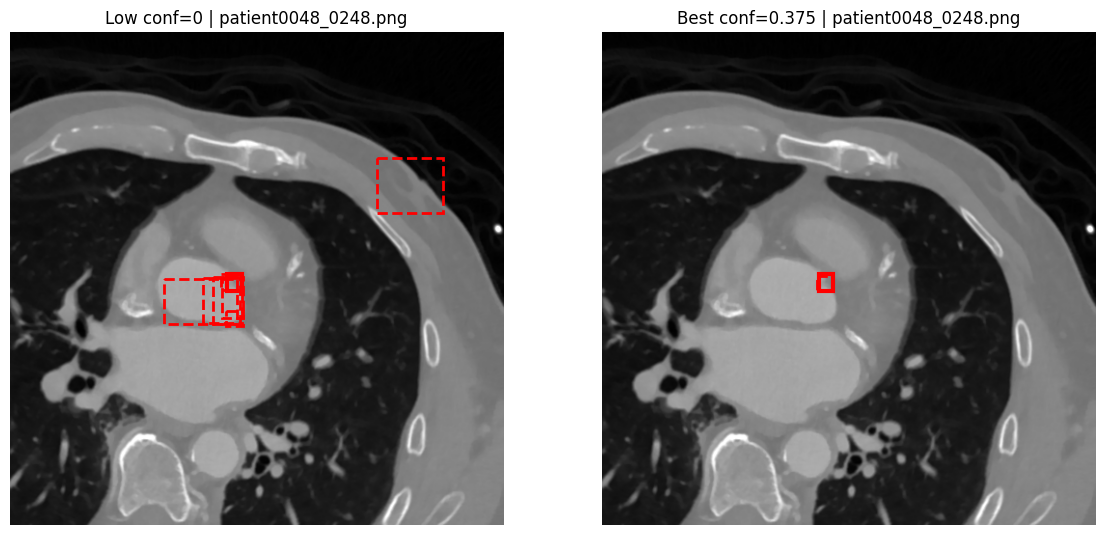

GT：實線框；Pred：虛線框（文字為 conf）


In [20]:
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob, random

MODEL_PATH = "/content/best_9m_110.pt"
TEST_IMG_DIR = Path("/content/datasets/test/images")
TEST_LBL_DIR = Path("/content/datasets/test/labels")
IMGSZ = 512
DEVICE = 0

LOW_CONF = 0
BEST_CONF = 0.375   # <- TODO：改成你「Best F1 at conf≈0.xxx」印出的那個值

# ----------工具：讀 GT（支援多框）----------
def read_yolo_labels(label_path: Path):
    if not label_path.exists():
        return []
    lines = label_path.read_text().strip().splitlines()
    out = []
    for ln in lines:
        if not ln.strip():
            continue
        p = ln.split()
        if len(p) < 5:
            continue
        x, y, w, h = map(float, p[1:5])
        out.append((x, y, w, h))
    return out

def xywhn_to_xyxy_pixels(xywhn, W, H):
    x, y, bw, bh = xywhn
    x1 = (x - bw/2) * W
    y1 = (y - bh/2) * H
    x2 = (x + bw/2) * W
    y2 = (y + bh/2) * H
    return np.array([x1, y1, x2, y2], dtype=np.float32)

def list_images(img_dir: Path):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp")
    paths = []
    for e in exts:
        paths += glob.glob(str(img_dir / e))
    return sorted(map(Path, paths))

def draw_boxes(ax, img_arr, gt_boxes, pred_boxes, pred_confs, title):
    ax.imshow(img_arr)
    ax.set_title(title)
    ax.axis("off")

    # GT：紅色實線框
    for b in gt_boxes:
        x1, y1, x2, y2 = b
        ax.add_patch(
            plt.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                edgecolor="red",
                linewidth=3
            )
        )

    # Pred：紅色虛線框
    for b in pred_boxes:
        x1, y1, x2, y2 = b
        ax.add_patch(
            plt.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                edgecolor="red",
                linewidth=2,
                linestyle="--"
            )
        )


# ----------選一張有 GT 的 test 圖----------
img_paths = list_images(TEST_IMG_DIR)
candidates = []
for ip in img_paths:
    lp = TEST_LBL_DIR / f"{ip.stem}.txt"
    if lp.exists() and lp.read_text().strip():
        candidates.append(ip)

if not candidates:
    raise ValueError("找不到有標註的 test 圖，請確認 /content/datasets/test/labels")

ip = random.choice(candidates)
img = Image.open(ip).convert("RGB")
img_arr = np.array(img)
W, H = img.size

# GT boxes
gt_norm = read_yolo_labels(TEST_LBL_DIR / f"{ip.stem}.txt")
gt_xyxy = [xywhn_to_xyxy_pixels(xywhn, W, H) for xywhn in gt_norm]

# ----------模型推論：低 conf vs 最佳 conf----------
model = YOLO(MODEL_PATH)

def predict_boxes(conf_thr):
    r = model.predict(source=str(ip), imgsz=IMGSZ, device=DEVICE, conf=conf_thr, verbose=False)[0]
    if r.boxes is None or len(r.boxes) == 0:
        return [], []
    confs = r.boxes.conf.detach().cpu().numpy()
    boxes = r.boxes.xyxy.detach().cpu().numpy()
    # 只取前 8 個，避免低 conf 太亂
    order = np.argsort(-confs)[:8]
    boxes = boxes[order].astype(np.float32).tolist()
    confs = confs[order].astype(float).tolist()
    return boxes, confs

pred_low, conf_low = predict_boxes(LOW_CONF)
pred_best, conf_best = predict_boxes(BEST_CONF)

# ----------畫比較圖（左右並排）----------
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
draw_boxes(axes[0], img_arr, gt_xyxy, pred_low, conf_low,  f"Low conf={LOW_CONF} | {ip.name}")
draw_boxes(axes[1], img_arr, gt_xyxy, pred_best, conf_best, f"Best conf={BEST_CONF} | {ip.name}")
plt.show()

print("GT：實線框；Pred：虛線框（文字為 conf）")


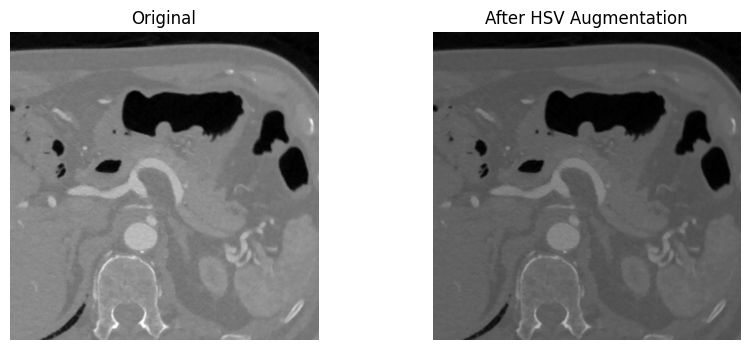

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def yolo_hsv_augment(img, hgain=0.015, sgain=0.7, vgain=0.4):
    """
    模擬 YOLO 的 HSV augmentation（邏輯與 Ultralytics 相同）
    """
    img = img.copy()
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 0] = (hsv[..., 0] * r[0]) % 180
    hsv[..., 1] = np.clip(hsv[..., 1] * r[1], 0, 255)
    hsv[..., 2] = np.clip(hsv[..., 2] * r[2], 0, 255)

    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

# 讀一張圖
img = cv2.imread("/content/training_image/training_image/patient0001/patient0001_0001.png")

aug = yolo_hsv_augment(img)

# 顯示
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(aug, cv2.COLOR_BGR2RGB))
plt.title("After HSV Augmentation")
plt.axis("off")

plt.show()
